# Adam: Adptive Moment Estimation
In this project I implement the Adam stochastic optimization algorithm from Kingma and Ba (2015) for a simple neural net classifier. Stochastic optimization seeks to minimize the expected value of the objective function rather than the objective function itself. The idea is that the objective function changes stochastically for different batches of data, so it is necessary to find an average of these functions. The Adam algorithm calculates an expoentially decaying moving average of gradients to obtain the mean (first moment) and uncentered variance (second raw moment). Through a clever trick the moving average becomes only dependent on the previous gradient. The "adaptive" part is that the step size is proportional the ratio of the mean to the standard deviation, meaning the weight update takes larger steps if we find a gradient with low variance. Section 2 of the paper (https://arxiv.org/pdf/1412.6980.pdf) provides a more detailed description.

The first part of the code is basically identical to the Neural Net Classifier Code:


In [1]:
# -*- coding: utf-8 -*-
"""
@author: Will
"""
import numpy as np
import matplotlib.pyplot as plt
import math as mt


##sigmoid function
def sigmoid(eta):
    if eta>1e2:
        return 1.0
    if eta <-1e2:
        return 0.0
    else:
        return 1/(1+mt.exp(-eta))

##derivative is just s*(1-s). nice
def sigmoid_grad(eta):
    return sigmoid(eta)*(1-sigmoid(eta))

##dot product function
def dot(a,b):
    tot = 0
    for i in range(len(a)):
        tot = tot+(a[i]*b[i])
        
    return(tot) 

##this just returns index of your highest item
def argmax(f):
    return f.index(max(f))
##Create NN 

#function that computes Z_mis. non-linear
##essentially what we are doing is transforming our data to put into a regression model
##but that transformation is fit to the data!
def Zfunc(alpha,x,M):
    
    ##eta stores the arguments for sigmoid function in length M vectors for data point i
    eta = [[] for i in range(len(x))]
    ##this fills in the eta vector
    for i in range(len(x)):
        eta[i] = [alpha[m][0]+dot(alpha[m][1:],x[i]) for m in range(M)]
    
    ##calculates z using eta and sigmoid. stores in length M vectors for data point i
    z = [[sigmoid(eta[i][m]) for m in range(M)] for i in range(len(x))]
    #print(z[0][0])
    return z
##test Z: print(Zfunc([[1,1,1],[0,0,0]],[[1,1]],2))

##function that computes T_kis. This step is linear
def Tfunc(beta,z,K):
    T = [[] for i in range(len(z))]
    #cycles through class j of k and creates T_ks for each data i in z
    for i in range(len(z)):
        T[i] = [beta[k][0]+dot(beta[k][1:],z[i]) for k in range(K)]
    
    return T
##test T: print(Tfunc([[0,1,1]],[[.5,.5]],1))
##function that normalizes T - would only use for classification
##returns k-length vector to be used in f function with values in {0-1}. 
#Max argument of vector is class    
def softmax(K,T):
    if K ==0:
        K = 1
    tot =0
    for k in range(K):
        tot = tot + mt.exp(T[k])
    g = [mt.exp(T[k])/tot for k in range(K)]
    return g
##test softmax print(softmax(2,[.5,.5]))

##the gradient is pretty convinient actually...
def softmax_grad(K,T):
    g = softmax(K,T)
    return [g[i]*(1- g[i]) for i in range(len(g))]

##function that computes f_kis. will output n length vector of k-length vectors
##with values between 0 and 1.
##the max value of each k-length vector is the class
def Ffunc(T,K):
    f = [[] for i in range(len(T))]
    for i in range(len(T)):
        f[i] = softmax(K,T[i])
        
    return f
#Test Ffunc: print(Ffunc([[.5,.5]],2))
    
##function that computes error - use sum of squared errors
def Rfunc(y,f):
    error = 0
    for i in range(len(y)):
        for k in range(len(y[0])):
            error = error + (y[i][k]-f[i][k])**2
    return error
#test Rfunc: print(Rfunc([[0,1]],[[1,0]]))
    
##add penalty to error - remember to use weight decay lambda...
#dont actually use this anywhere just for kicks
def Jfunc(R, alpha, beta):
    beta_sum = 0
    alpha_sum = 0
    
    for k in range(len(beta)):
        for m in range(len(beta[0])):
            beta_sum = beta_sum + beta[m]**2
            
    for m in range(len(alpha)):
        for l in range(len(alpha[0])):
            alpha_sum = alpha_sum + alpha[l]**2
    
    return alpha_sum + beta_sum

##gradient functions for steepest descent
##gradient with respect to beta
def beta_grad(beta,y,x,M,K,f,z,T,lam):
    ##store as vector of vector of vector of ms in ks in is
    grad = [[np.zeros(M+1) for k in range(K)] for i in range(len(x))]
    ##fill er up
    for i in range(len(x)): ##each data point
        for k in range(K): ##each class
            for m in range(1,M+1): ##each unit
                grad[i][k][m] = -2*(y[i][k]-f[i][k])*softmax_grad(K,T[i])[k]*z[i][m-1]#+2*lam*beta[k][m]
    ##the penalty function is causing issues! remove it we dont need you
    #print (grad[4][0])            
    return grad

##gradient with respect to alpha
def alpha_grad(alpha,beta,y,x,M,K,f,z,T,lam):
    ##store as vector of vector of ls in ms in is
    L = len(alpha[0])
    grad = [[np.zeros(L) for i in range(M)] for j in range(len(x))]
    ##fill er up
    Ktot  = 0
    for i in range(len(x)): ##each data point
        for m in range(1,M): ##each unit
            for l in range(1,L): ##each alpha
                Ktot = 0
                for k in range(K):
                    Ktot = Ktot + 2*(y[i][k] - f[i][k])*-1*softmax_grad(K,T[i])[k]*beta[k][m]*sigmoid_grad(dot(alpha[m][1:],x[i]))*x[i][l-1]#+2*lam*alpha[m][l]
                grad[i][m][l] = -Ktot
    ##remove penalty
    #print(grad[4][1])
    return grad


##need to change this to return gradient of each component of beta

def beta_grad_tot(beta,x,K,M,grad):
    beta_grad = [[0] for k in range(K)]
    for k in range(K): ##each class
        for m in range(1,M+1): ##each unit
            tot = 0
            for i in range(len(x)): ##each data point 
                tot = tot + grad[i][k][m]
            #print(tot)
            beta_grad[k].append(tot) 
    return(beta_grad)


def alpha_grad_tot(alpha,x,M,grad):
    alpha_grad =[[] for i in range(M)]
    L = len(alpha[0])
    
    for m in range(0,M):
        for l in range(0,L):
            tot = 0 
            for i in range(len(x)):##cylces through all data points
                tot = tot + grad[i][m][l]
                
            alpha_grad[m].append(tot)
    return(alpha_grad)

The first of these two functions, pick_data, splits up the data into 10 bins and randomly chooses one. I later shuffle the data so the each bin will contain a random slice. The second function implements the Adam algorithm. See section one of the paper linked above for the psuedocode. Before the while loop constants and weights are initialized, and in the loop the weights are updated. Every 100 iterations the error is evaluated so it can be plotted and compared to steepest descent.

In [2]:
def pick_data(X,Y):
    ##returns a random data slice
    rando = int(np.random.rand()*10)
    slice_ = int(len(X)/10)
    ind = rando*slice_
    return X[ind:ind+slice_], Y[ind:ind+slice_]


def ADAM(alpha1,beta1,beta2,X,Y,M,K,lam):
    L = len(X[0])
    alpha = np.random.rand(M,L+1)-.5
    beta = np.random.rand(K,M+1)-.5
    theta = np.array([alpha,beta])
    ##m and v are lists with alpha, beta size
    m_t = np.array([np.zeros([M,L+1]),np.zeros([K,M+1])])
    v_t = m_t
    t=0
    it = 0
    converged = False    
    iterations = []
    error = []
    while not converged:
        
        ##pick a random 1/10 slice of training data
        x_t,y_t = pick_data(X,Y)
        t = t+1
        alpha= theta[0]
        beta = theta[1]
        ##backprop  to get some gradients
        Z = Zfunc(alpha,x_t, M)
        T = Tfunc(beta,Z,K)
        f = Ffunc(T,K)
        
        a_grad_partial = alpha_grad(alpha,beta,y_t,x_t,M,K,f,Z,T,lam) 
        b_grad_partial = beta_grad(beta,y_t,x_t,M,K,f,Z,T,lam)
        
        a_grad = np.array(alpha_grad_tot(alpha,x_t,M,a_grad_partial))
        b_grad = np.array(beta_grad_tot(beta,x_t,K,M,b_grad_partial))
        
        g_t = np.array([a_grad,b_grad])
        
        m_t =m_t*beta1 + (1-beta1)*g_t 
        v_t = beta2*v_t + (1-beta2)*(g_t**2)
        
        m_hat_t = m_t/(1-beta1**t)
        v_hat_t = v_t/(1-beta2**t)
        
        theta = theta - alpha1*m_hat_t/((v_hat_t)**(.5)+1e-8)
        
        it+=1
        ##check error every 100 iterations
        if it%100 == 0:
            Z = Zfunc(alpha,X,M)
            T = Tfunc(beta,Z,K)
            F = Ffunc(T,K)
            err_t = Rfunc(Y,F)
            iterations.append(it)
            error.append(err_t)
#
            if err_t <10:
                converged = True
    
    plt.plot(iterations,error)
    plt.xlabel("Iteration")
    plt.ylabel("Sum of Squared Error")
    return theta
        


## Try on Iris Data
This code is pretty much the same as in the Neural Net Classifier notebook - I create usable data and then test it out.

training


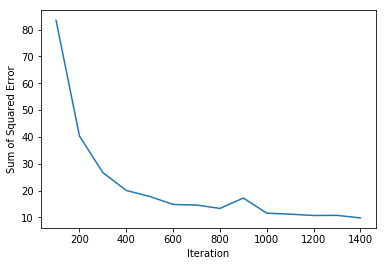

In [5]:
import pandas as pd
iris = pd.read_excel(r'C:/Users/Will/Desktop/Projects/Iris.xlsx')
iris = pd.DataFrame(iris)
##shuffle them datas
iris = iris.sample(frac=1).reset_index(drop=True)
X1 = np.asarray(iris['petal_length'])
X1norm = sum(X1)
X1 = X1/X1norm
X2 = np.asarray(iris['petal_width'])
X2norm= sum(X2)
X2=X2/X2norm
Y0 = np.asarray(iris['Y'])

##reformat x into a vector of [X1,X2] pairs and y into length 3 vector with
##class 1 = setosa, class 2 = versicolor class 3 = virginica
X = [[X1[i],X2[i]] for i in range(len(X1))]
Y = [[] for i in range(len(Y0))]
for i in range(len(Y0)):
    if Y0[i]==0:
        Y[i] = [1,0,0]
    elif Y0[i]==1:
        Y[i]=[0,1,0]
    else:
        Y[i]=[0,0,1]

M=2
K=3

##here we go folks
print 'training'
result = ADAM(.5,.9,.999,X,Y,M,K,1)

## Visualize the Data
This code is also nearly identical to that in the Classifier notebook.

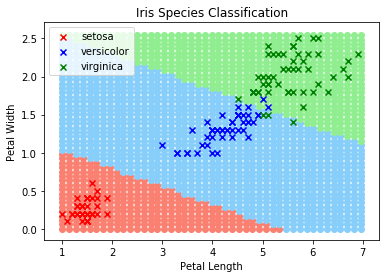

In [6]:
Z = Zfunc(result[0],X, M)
T = Tfunc(result[1],Z,K)
F = Ffunc(T,K)

def classifyIris(f):
    out = [[] for i in range(len(f))]
    for i in range(len(f)):
        cls = argmax(f[i])
        if cls ==0:
            out[i] = [1,0,0]
        elif cls ==1:
            out[i]=[0,1,0]
        else:
            out[i]=[0,0,1]
    return out
            
predict = classifyIris(F)
percent = 0.
for i in range(len(predict)):
    if predict[i]==Y[i]:
        percent = percent + 1

percent = percent/len(predict)


X1Test = np.arange(1,7.1,6.1/45.)/X1norm
X2Test = np.arange(0,2.6,2.6/45.)/X2norm
X1M, X2M = np.meshgrid(X1Test,X2Test)
XTest = [[] for i in range(len(X1M))]
for i in range(len(X1M)):
    XTest[i] = [ [X1M[i][j],X2M[i][j]] for j in range(len(X1M))]
    

def Test(X,theta,K,M):
    alpha =theta[0]
    beta = theta[1]
    Z = Zfunc(alpha,X, M)
    T = Tfunc(beta,Z,K)
    f = Ffunc(T,K)
    
    #print err
    return f


            
test = [Test(XTest[i],result,K,M) for i in range(len(XTest))]
testpredict =[classifyIris(test[i]) for i in range(len(test))]
##now bring the data back around to what u want
X1Test = np.arange(1,7.1,6.1/45.)
X2Test = np.arange(0,2.6,2.6/45.) 
X1M, X2M = np.meshgrid(X1Test,X2Test)
##orgnize into data pairs
for i in range(len(X1M)):
    XTest[i] = [[X1M[i][j],X2M[i][j]] for j in range(len(X1M))]
for i in range(len(XTest)):
    for j in range(len(XTest[0])):
        if testpredict[i][j]==[1,0,0]:
            plt.scatter(XTest[i][j][0],XTest[i][j][1],color='salmon')
        elif testpredict[i][j]==[0,1,0]:
            plt.scatter(XTest[i][j][0],XTest[i][j][1],color='lightskyblue')
        else:
            plt.scatter(XTest[i][j][0],XTest[i][j][1],color='lightgreen')

plt.scatter((iris[iris.Y==0]['petal_length']),(iris[iris.Y==0]['petal_width']),color='red',marker='x',label = 'setosa')
plt.scatter((iris[iris.Y==1]['petal_length']),(iris[iris.Y==1]['petal_width']),color='blue',marker='x',label = 'versicolor')
plt.scatter((iris[iris.Y==2]['petal_length']),(iris[iris.Y==2]['petal_width']),color='green',marker='x', label = 'virginica')
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.title("Iris Species Classification")
plt.legend()

# Conclusions
The Adam solver shows similar abilities to the steepest descent solver, and the run time is considerably faster. I think this is mostly a function of using small subsets of the data for back-propagation rather than the entire set each time. Below is the convergence plot for steepest descent, which is smoother and takes fewer iterations than Adam. However, each iteration is computationally more difficult, so the run time is longer: 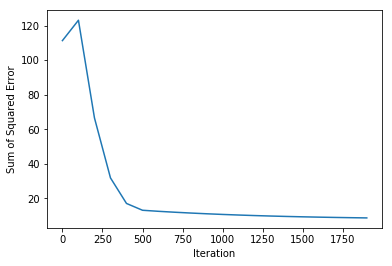